In [58]:
import pandas as pd
import numpy as np
import codecs
import re
from os import path, listdir
import matplotlib.pyplot as plt
import numpy as np

In [59]:
# from google.colab import drive
# drive.mount('/content/drive')

In [60]:
# pwd = '/content/drive/My Drive/Colab Notebooks/tpa/'
pwd = './'
monolith_dir = path.join(pwd, 'monolith')
monolith = path.join(monolith_dir, 'final_tweets.csv')

In [61]:
root = pd.read_csv(monolith, dtype={
  'tweet_id': str
  # 'tweet_text': str, 'tweet_id': str, 'user_name': str, 'user_screen_name': str,
  # 'user_location': str, 'user_description': str, 'user_follower_count': int,
  # 'user_friends_count': int, 'user_listed_count': int, 'user_statuses_count': int,
  # 'user_favourites_count': int, 'user_verified': bool, 'user_default_profile_image': bool,
  # 'user_default_profile': bool, 'user_protected': bool, 'user_created_at': str
}, engine='c', chunksize=500)
chunks = [chunk for chunk in root]
root = pd.concat(chunks)

In [62]:
root = root.dropna()
print(root.shape)
print(root.dtypes)

(389361, 16)
tweet_text                    object
tweet_id                      object
user_name                     object
user_screen_name              object
user_location                 object
user_description              object
user_follower_count           object
user_friends_count            object
user_listed_count             object
user_statuses_count           object
user_favourites_count         object
user_verified                 object
user_default_profile_image    object
user_default_profile          object
user_protected                object
user_created_at               object
dtype: object


In [63]:
# find users

users = {}

user_fields = [
  'user_name', 'user_screen_name', 'user_location',
  'user_description', 'user_follower_count', 'user_friends_count',
  'user_listed_count', 'user_statuses_count', 'user_favourites_count',
  'user_verified', 'user_default_profile_image', 'user_default_profile',
  'user_protected', 'user_created_at'
]

for _, row in root.iterrows():
  un = str(row['user_screen_name'])
  if un in users:
    for k in user_fields:
      users[un][k] = users[un][k] or row[k]
    # append tweet to user object
    users[un]['tweets'].append({row['tweet_id']: row['tweet_text']})
  else:
    users[un] = {}
    users[un] = {k: row[k] for k in user_fields}
    users[un]['tweets'] = [{row['tweet_id']: row['tweet_text']}]
    users[un]['bot'] = False

print('Unique users', len(users))

Unique users 46531


In [64]:
print(list(users.values())[0])

{'user_name': 'Pooja Choudhary', 'user_screen_name': 'pooojachoudhary', 'user_location': 'Delhi', 'user_description': 'Hindustani 🇮🇳 | 22 | Designer | Average Artist | Feminist | Vegetarian | Instagram: @pooojachoudhary 💌', 'user_follower_count': '53', 'user_friends_count': '31', 'user_listed_count': '0', 'user_statuses_count': '219', 'user_favourites_count': '2160', 'user_verified': False, 'user_default_profile_image': False, 'user_default_profile': True, 'user_protected': False, 'user_created_at': '2019-10-06 13:05:14', 'tweets': [{'1231982201656483841': 'मेरी दिल्ली जल रही है एक बार फिर से 💔#DelhiBurning'}], 'bot': False}


In [65]:
# find descs

descs = {}

for row in users.values():
  un = str(row['user_description']).lower()
  if un in descs:
    descs[un] = descs[un] + 1
  else:
    descs[un] = 1

print('Unique descriptions')

for l in sorted(zip(descs.keys(), descs.values()), key=lambda t: t[1], reverse=True)[:25]:
  print(l)

Unique descriptions
('indian', 95)
('student', 85)
('journalist', 41)
('🇮🇳', 28)
('.', 26)
('male', 24)
('social worker', 18)
('mechanical engineer', 16)
('civil engineer', 16)
('proud indian', 16)
('social activist', 14)
('jai hind', 13)
('engineer', 12)
('software engineer', 12)
('i love my india', 12)
('proud indian 🇮🇳', 11)
('nationalist', 11)
('indian🇮🇳', 11)
('entrepreneur', 11)
('nation first', 11)
('जय श्री राम', 10)
('chartered accountant', 10)
('common man', 9)
('writer', 9)
('politician', 9)


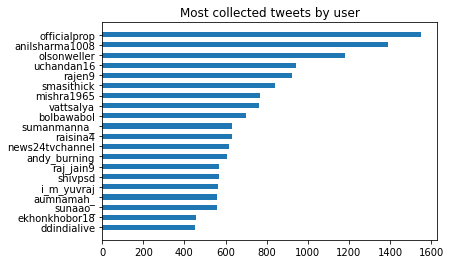

In [66]:
# find most active users

active_users = {}

for user in users.values():
  un = str(user['user_screen_name']).lower()
  active_users[un] = {'tweets': len(user['tweets']), 'statuses': row['user_statuses_count'] if str(row['user_statuses_count']).isdigit() else 0}

# print('Most tweets by users', len(active_users))
# for l in sorted(zip(active_users.keys(), active_users.values()), key=lambda t: t[1]['tweets'], reverse=True)[:20]:
#   print(l)
top_20 = reversed(sorted(active_users.items(), key=lambda t: t[1]['tweets'], reverse=True)[:20])
plt.barh(*zip(*list(map(lambda t:(t[0], t[1]['tweets']), top_20))), height=0.5)
plt.title('Most collected tweets by user')
plt.show()

In [67]:
# self identified bots

for un, user in users.items():
  un = un.lower()
  desc = user['user_description'].lower()
  name = user['user_name'].lower()
  if un.startswith('bot') or un.endswith('bot'):
    print(un)
    continue
  # if re.compile('((^bot\s+)|(\s+bot\s+)|(\s+bot$))').match(desc):
  #   print(un)
  #   continue
  # if re.compile('((^bot\s+)|(\s+bot\s+)|(\s+bot$))').match(name):
  #   print(un)
  #   continue

bothrapawan53
gyuslovebot
bot8point2
larryheatherbot
humaibot
nypdbot
twelvebot
botanist77
weebsyntaxbot
indianaimbot
ex0bot


In [68]:
# all users within 1 year of creation date and tweets per day

from datetime import datetime
now = datetime.strptime('2020-03-01 00:00:00', '%Y-%m-%d %H:%M:%S')
# now = datetime.now()

print(now)

relatively_new_users = []

for user in users.values():
  acct_creation_time = datetime.strptime(user['user_created_at'], '%Y-%m-%d %H:%M:%S')
  if acct_creation_time > datetime(2019, 1, 1):
    tweets_per_day = int(user['user_statuses_count']) / (now - acct_creation_time).days
    if tweets_per_day > 100:
      # print(user['user_screen_name'], tweets_per_day)
      relatively_new_users.append((user['user_screen_name'], tweets_per_day))

print('Relatively new users count:', len(relatively_new_users))
print('Average tweet count of new users:',
      sum(map(lambda t:t[1], relatively_new_users)) / len(relatively_new_users))

2020-03-01 00:00:00
Relatively new users count: 366
Average tweet count of new users: 173.98413927617088


In [69]:
# users with very poor ratio of (friends / followers) count

users_poor_ratio = []

for un, user in users.items():
  followers = int(user['user_follower_count'])
  friends = int(user['user_friends_count']) or 1
  ratio = followers / friends

  # Friends >5000 is too obvious
  # Ratio >0.85 is too close to close friends and followers

  if friends > 5000 and ratio > 0.85 and not user['user_verified']:
    # print(followers, friends, un)
    users_poor_ratio.append(un)
  # print(ratio, followers, friends)

print(len(users_poor_ratio))

1195


In [70]:
# average retweets by users with poor follower/friend ratio

rt_count_by_user = [
  len(list(filter(lambda s: s.values() and str(list(s.values())[0]).startswith('RT '), user['tweets'])))
  for user in list(map(lambda un:users.get(un), users_poor_ratio))
]

print(sum(rt_count_by_user) / len(rt_count_by_user))

0.10794979079497909


In [71]:
# find RTs

RTs = []

for _, row in root.iterrows():
  text = str(row['tweet_text'])
  if text.startswith('RT '):
    RTs.append(row['tweet_id'])

print('Total RTs', len(RTs), len(root))

Total RTs 3603 389361


In [102]:
# start flagging

bots = set()
not_bots = set()

for un, user in users.items():
  # bot in name
  if un.startswith('bot') or un.endswith('bot'):
    bots.add(un)

  # ton of tweets per day (upto Mar 1 2020)
  acct_creation_time = datetime.strptime(user['user_created_at'], '%Y-%m-%d %H:%M:%S')
  acct_age = (datetime(2020, 3, 1) - acct_creation_time).days or 1
  tweets_per_day = int(user['user_statuses_count']) / acct_age
  favorites_count = int(user['user_favourites_count'])
  favorites_per_day = favorites_count / acct_age
  friends_count = int(user['user_friends_count'])

  if tweets_per_day > 150 and (user['user_default_profile_image'] or user['user_default_profile'] or not user['user_verified']):
    bots.add(un)

  # user with very poor ratio of (followers / friends) count
  followers = int(user['user_follower_count'])
  friends = int(user['user_friends_count']) or 1
  ratio = followers / friends
  if friends > 5000 and ratio > 0.85 and tweets_per_day > 50 and not user['user_verified']:
    bots.add(un)
  
  if followers > 10000 and not user['user_verified'] and (favorites_per_day > 300 or favorites_count > 50):
    bots.add(un)

  # young users with poor ratio of (followers / friends) count (6 months)
  if acct_creation_time > datetime(2019, 6, 1):
    if friends > 500 and ratio > 0.85 and tweets_per_day > 50:
      bots.add(un) # poor ratio

  if followers > 3000 and friends_count < 50 and tweets_per_day > 100 and acct_age < 1000:
    bots.add(un)

  if un not in bots:
    not_bots.add(un)
print(len(bots), '---> {}%'.format(len(bots)/len(users)))
print(list(bots)[-10:])

2183 ---> 0.04691495991919366%
['Sandeep68260056', 'inquestioner', 'IM_MAhiDixiT', 'AmbreenPTI1', 'M_A_Wahidi', 'ZartashChaudhry', 'chitralekhamag', 'Jainpankajkasan', 'Chirag_Sinh13', 'KO666Cis']


In [88]:
# average retweets by bots and notbots

rt_count_by_bot_user = [
  len(list(filter(lambda s: s.values() and str(list(s.values())[0]).startswith('RT '), user['tweets'])))
  for user in list(map(lambda un:users.get(un), bots))
]

rt_count_by_notbot_user = [
  len(list(filter(lambda s: s.values() and str(list(s.values())[0]).startswith('RT '), user['tweets'])))
  for user in list(map(lambda un:users.get(un), not_bots))
]

print(sum(rt_count_by_bot_user) / len(rt_count_by_bot_user))
print(sum(rt_count_by_notbot_user) / len(rt_count_by_notbot_user))

0.14383875400824553
0.07416343465319744


In [89]:
# average status counts by bots and notbots

status_count_by_bot_user = [
  int(user['user_statuses_count'])
  for user in list(map(lambda un:users.get(un), bots))
]

status_count_by_notbot_user = [
  int(user['user_statuses_count'])
  for user in list(map(lambda un:users.get(un), not_bots))
]

total_status_count = sum(status_count_by_bot_user) + sum(status_count_by_notbot_user)
print(sum(status_count_by_bot_user) / len(bots), '-', len(bots), sum(status_count_by_bot_user) / total_status_count * 100, '%')
print(sum(status_count_by_notbot_user) / len(not_bots), '-', len(not_bots), sum(status_count_by_notbot_user) / total_status_count * 100, '%')

95881.40907008703 - 2183 27.261807963226104 %
12592.789753765672 - 44348 72.7381920367739 %


In [90]:
# check min and max followers

min_followers = 2**32
max_followers = -min_followers
min_followers_user = ''
max_followers_user = ''

for user in users.values():
  followers = int(user['user_follower_count']) if str(user['user_follower_count']).isdigit() else 0
  if followers > max_followers:
    max_followers = followers
    max_followers_user = user['user_screen_name']

  if followers < min_followers:
    min_followers = followers
    min_followers_user = user['user_screen_name']

print(min_followers, min_followers_user)
print(max_followers, max_followers_user)

0 belalahmad1993
45234397 nytimes


In [91]:
# favorite count based on bots and not bots

print(sum([
  int(user['user_favourites_count']) if str(user['user_favourites_count']).isdigit() else 0
  for user in map(lambda un:users.get(un), bots)
]))

print(sum([
  int(user['user_favourites_count']) if str(user['user_favourites_count']).isdigit() else 0
  for user in map(lambda un:users.get(un), not_bots)
]))

101757212
532920281


[44176, 1993, 298, 64]


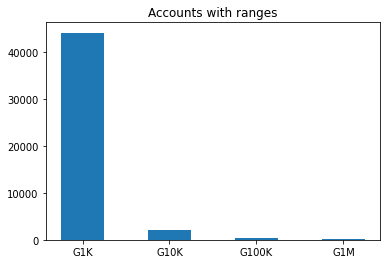

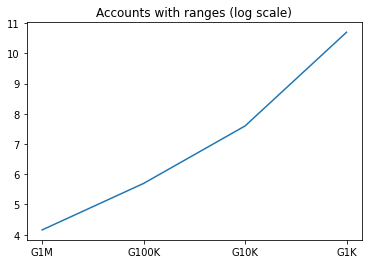

In [93]:
# Get users in ranges
# 0 to 10K - G1K
# 10K to 100K - G10K
# 100K to 1M - G100K
# 1M+ - G1M

G1K = []
G10K = []
G100K = []
G1M = []

for user in users.values():
  followers = int(user['user_follower_count']) if str(user['user_follower_count']).isdigit() else 0
  un = user['user_screen_name']
  if followers < 10000:
    G1K.append((un, followers))
  elif followers < 100000:
    G10K.append((un, followers))
  elif followers < 1000000:
    G100K.append((un, followers))
  else:
    G1M.append((un, followers))

ranges = ['G1K', 'G10K', 'G100K', 'G1M']
sizes = [len(G1K), len(G10K), len(G100K), len(G1M)]

# 46K users with < 100K folowers
# Got [46127, 306, 56, 7] for 'G1K', 'G100K', 'G1M', 'G10M'

# [44116, 2011, 306, 63] for 'G1K', 'G10K', 'G100K', 'G1M'

print(sizes)

plt.bar(np.arange(len(ranges)), sizes, width=0.5)
plt.xticks(np.arange(len(ranges)), ranges)
plt.title('Accounts with ranges')
plt.show()

plt.plot(np.arange(len(ranges)), list(reversed(list(map(np.log, sizes)))))
plt.xticks(np.arange(len(ranges)), list(reversed(ranges)))
plt.title('Accounts with ranges (log scale)')
plt.show()

[545, 1569, 65, 4]


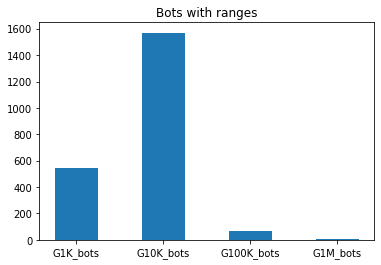

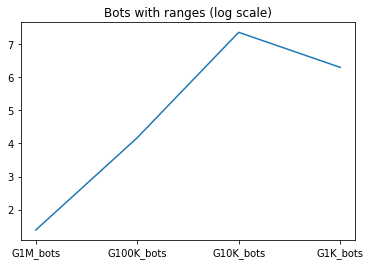

In [94]:
# Get bots and notbots in ranges
# 0 to 10K - G1K
# 10K to 100K - G10K
# 100K to 1M - G100K
# 1M+ - G1M

G1K_bots = []
G10K_bots = []
G100K_bots = []
G1M_bots = []

for bot in bots:
  user = users.get(bot)
  followers = int(user['user_follower_count']) if str(user['user_follower_count']).isdigit() else 0
  if followers < 10000:
    G1K_bots.append((bot, followers))
  elif followers < 100000:
    G10K_bots.append((bot, followers))
  elif followers < 1000000:
    G100K_bots.append((bot, followers))
  else:
    G1M_bots.append((bot, followers))

ranges = ['G1K_bots', 'G10K_bots', 'G100K_bots', 'G1M_bots']
sizes = [len(G1K_bots), len(G10K_bots), len(G100K_bots), len(G1M_bots)]

print(sizes)
# print(G10K_bots)

plt.bar(np.arange(len(ranges)), sizes, width=0.5)
plt.xticks(np.arange(len(ranges)), ranges)
plt.title('Bots with ranges')
plt.show()

plt.plot(np.arange(len(ranges)), list(reversed(list(map(np.log, sizes)))))
plt.xticks(np.arange(len(ranges)), list(reversed(ranges)))
plt.title('Bots with ranges (log scale)')
plt.show()

In [95]:
# RT not endorsement text in user description
import re

endorse = re.compile('RT not endorsement', re.IGNORECASE)

rtne = [
  un for un in users.keys()
  if re.search(endorse, users.get(un)['user_description'])
]
print(len(rtne))

101


In [96]:
# Save to file, final attributes
# Final attributes
#   screen_name - just for debugging, ignore in final
#   acct_age
#   follower_count
#   friends_count
#   statuses_count
#   favorites_count
#   avg_status_count
#   verified_acct
#   default_image
#   default_profile
#   rel_new_acct
#   isbot

from os import path
import csv

header = [
  'screen_name', 'acct_age', 'follower_count', 'friends_count', 'statuses_count',
  'favorites_count', 'avg_status_count', 'verified_acct', 'default_image',
  'default_profile', 'rel_new_acct', 'isbot'
]

final_users = []

young_date = datetime(2019, 6, 1)

# pwd = '/content/drive/My Drive/Colab Notebooks/tpa/'
pwd = './'
features_file = path.join(pwd, 'monolith', 'features.csv')

with open(features_file, 'w', newline='\n', encoding='utf-8') as f:
  writer = csv.writer(f)

  # write header
  writer.writerow(header)

  def todigit(st):
    return int(st) if str(st).isdigit() else 0

  for user in users.values():
    acct_creation_time = datetime.strptime(user['user_created_at'], '%Y-%m-%d %H:%M:%S')

    screen_name = user['user_screen_name']
    tweets = user['tweets']
    follower_count = todigit(user['user_follower_count'])
    friends_count = todigit(user['user_friends_count'])
    statuses_count = todigit(user['user_statuses_count'])
    favorites_count = todigit(user['user_favourites_count'])
    acct_age = (datetime(2020, 3, 1) - acct_creation_time).days
    tweets_per_day = int(user['user_statuses_count']) / acct_age

    new_user = {
      'screen_name': screen_name,
      'acct_age': acct_age,
      'follower_count': follower_count,
      'friends_count': friends_count,
      'statuses_count': statuses_count,
      'favorites_count': favorites_count,
      'avg_status_count': tweets_per_day,
      'verified_acct': 1 if user['user_verified'] else 0,
      'default_image': 1 if user['user_default_profile_image'] else 0,
      'default_profile': 1 if user['user_default_profile'] else 0,
      'rel_new_acct': 1 if acct_creation_time > young_date else 0,
      'isbot': 1 if user['user_screen_name'] in bots else 0
    }

    # write features
    writer.writerow(list(new_user.values()))

print('Done writing features')

Done writing features
